In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, glob, random, pickle

from tqdm import tqdm
import sklearn as sk

import xgboost as xgb
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
def metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2  = r2_score(y_true, y_pred)
    return mae, mse, r2


class baseline_model:
    """ Benchmark with the mean/median of the target variable """
    """ Ignore StandardScaler """
    def __init__(self, method: str = 'mean'):
        self.method = method # baseline method
        self.pred   = None   # predictions 
        
    def fit_baseline(self, train_input, train_target):
        if self.method == 'mean': self.pred = train_target.mean()
        elif self.method == 'median': self.pred = train_target.median()

    def get_pred(self, data):
        return np.tile(self.pred, (len(data), 1))

class linear_regression:
    """ Linear regression model """
    def __init__(self, method: str = 'linear', normalization: bool = True):
        self.method = method    # regression method
        self.normalization = normalization
        self.pred   = None # predictions
        self.model  = None # regression model
        self.scaler = None # standard scaler

    def fit_regress(self, train_input, train_target, normalization: bool = True, **kwargs):

        if self.method == 'linear': self.model = LinearRegression(**kwargs)
        elif self.method == 'lasso': self.model = Lasso(**kwargs)
        elif self.method == 'ridge': self.model = Ridge(**kwargs)
        elif self.method == 'elasticnet': self.model = ElasticNet(**kwargs)

        if self.normalization:
            self.scaler = StandardScaler()
            train_input = self.scaler.fit_transform(train_input) 

        self.model.fit(train_input, train_target) 

    def get_pred(self, data, normalization: bool = True):
        if self.model is None: raise ValueError("Model is not fitted yet")
        if self.normalization: 
            if self.scaler is None: raise ValueError("Standard scaler is not fitted yet")
            else: data = self.scaler.transform(data)

        return self.model.predict(data)

class random_forest:
    """ Random forest model """
    def __init__(self, normalization: bool = True): 
        self.pred   = None # predictions
        self.model  = None # regression model
        self.scaler = None # standard scaler 
        self.normalization = normalization
        
    def fit_forest(self, train_input, train_target, **kwargs):
        if self.normalization: 
            self.scaler = StandardScaler()
            transformed_train_input = self.scaler.fit_transform(train_input) 

        self.model = RandomForestRegressor(**kwargs)
        self.model.fit(transformed_train_input, train_target)
        self.importance = pd.DataFrame({'feature': train_input.columns, 'importance': self.model.feature_importances_}).sort_values(by='importance', ascending=False)
        
    def get_pred(self, input, **kwargs):
        if self.model is None: raise ValueError("Model is not fitted yet")
        if self.normalization: 
            if self.scaler is None: raise ValueError("Standard scaler is not fitted yet")
            else: input = self.scaler.transform(input)
        return self.model.predict(input, **kwargs)


class xgboost_regressor:
    """ XGBoost model """
    def __init__(self, normalization: bool = True):
        self.pred   = None # predictions
        self.model  = None # regression model
        self.scaler = None # standard scaler
        self.normalization = normalization
        self.importance = None

    def fit_xgboost(self, train_input, train_target, valid_input, valid_target, verbose: bool = False, **kwargs):
        if self.normalization: 
            self.scaler = StandardScaler()
            transformed_train_input = self.scaler.fit_transform(train_input) 
            transformed_valid_input = self.scaler.transform(valid_input)

        self.model = XGBRegressor(**kwargs)
        self.model.fit(transformed_train_input, train_target, eval_set=[(transformed_valid_input, valid_target)], verbose=verbose)
        self.importance = pd.DataFrame({'feature': train_input.columns, 'importance': self.model.feature_importances_}).sort_values(by='importance', ascending=False)

    def get_pred(self, input, **kwargs):
        if self.model is None: raise ValueError("Model is not fitted yet")
        if self.normalization: 
            if self.scaler is None: raise ValueError("Standard scaler is not fitted yet")
            else: input = self.scaler.transform(input)

        return self.model.predict(input, **kwargs)


def best_rf_search( train_input, train_target, params_grid, cv: int = 5, n_jobs: int = -1, verbose: bool = False, scoring = 'neg_mean_squared_error'):
    model  = RandomForestRegressor()
    grid_search = GridSearchCV(model , params_grid, scoring = scoring, n_jobs = n_jobs, cv = cv,  verbose = verbose  )
    grid_search.fit(train_input, train_target)
    return grid_search.best_params_, grid_search.best_score_


def best_xgb_search( train_input, train_target, valid_input, valid_target, params_grid, cv: int = 5, n_jobs: int = -1, verbose: bool = False, scoring = 'neg_mean_squared_error'):
    model = xgb.XGBRegressor()
    grid_search = GridSearchCV(model , params_grid,  scoring = scoring, n_jobs = n_jobs, cv = cv,  verbose = verbose  )
    grid_search.fit(train_input, train_target, eval_set=[(valid_input, valid_target)], verbose=verbose)
    return grid_search.best_params_, grid_search.best_score_



In [3]:
project_path = '/Users/k.choi/Documents/github/csiro_git'
data_path    = '/Users/k.choi/Documents/github/csiro_git/data'
img_path     = '/Users/k.choi/Documents/github/csiro_git/data/train'
test_path    = '/Users/k.choi/Documents/github/csiro_git/data/test'

train_df     = pd.read_csv(os.path.join(data_path, "train.csv"))
test_df      = pd.read_csv(os.path.join(data_path, "test.csv"))
rcomp_df      = pd.read_csv(os.path.join(project_path + '/stats', "complete_df.csv"))

In [4]:
rcomp_df.columns

metadata = ['State', 'Species', 'Pre_GSHH_NDVI', 'Height_Ave_cm']

In [5]:
state_encoder = LabelEncoder()
species_encoder = LabelEncoder()

comp_df = rcomp_df.copy()
comp_df['State'] = state_encoder.fit_transform(comp_df['State'])
comp_df['Species'] = species_encoder.fit_transform(comp_df['Species'])

print(' -- -- Species -- --' )
for i in np.unique(comp_df['Species']): print(i, species_encoder.inverse_transform([i]))
print(' -- -- State -- --' )
for i in np.unique(comp_df['State']): print(i, state_encoder.inverse_transform([i]))

 -- -- Species -- --
0 ['Clover']
1 ['Fescue']
2 ['Fescue_CrumbWeed']
3 ['Lucerne']
4 ['Mixed']
5 ['Phalaris']
6 ['Phalaris_BarleyGrass_SilverGrass_SpearGrass_Clover_Capeweed']
7 ['Phalaris_Clover']
8 ['Phalaris_Clover_Ryegrass_Barleygrass_Bromegrass']
9 ['Phalaris_Ryegrass_Clover']
10 ['Ryegrass']
11 ['Ryegrass_Clover']
12 ['SubcloverDalkeith']
13 ['SubcloverLosa']
14 ['WhiteClover']
 -- -- State -- --
0 ['NSW']
1 ['Tas']
2 ['Vic']
3 ['WA']


In [6]:
ndata   = len(comp_df); ntrain  = int(ndata * 0.8); nvalid = int(ndata * 0.1); ntest = ndata - ntrain - nvalid

comp_input = comp_df.drop(columns=['Dry_Total_g', 'Dry_Green_g', 'Dry_Dead_g', 'Dry_Clover_g', 'GDM_g', 'image_id', 'Sampling_Date'])
comp_target = comp_df[['Dry_Total_g', 'Dry_Green_g', 'Dry_Dead_g', 'Dry_Clover_g', 'GDM_g']]


train_img_input = comp_input.drop(columns=metadata).iloc[:ntrain]
train_input   = comp_input.iloc[:ntrain]
train_target  = comp_target.iloc[:ntrain]

valid_img_input = comp_input.drop(columns=metadata).iloc[ntrain:ntrain + nvalid]
valid_input   = comp_input.iloc[ntrain:ntrain + nvalid]
valid_target  = comp_target.iloc[ntrain:ntrain + nvalid]

test_img_input  = comp_input.drop(columns=metadata).iloc[ntrain + nvalid:]
test_input    = comp_input.iloc[ntrain + nvalid:]
test_target   = comp_target.iloc[ntrain + nvalid:]

print(f'train: {len(train_input)}, valid: {len(valid_input)}, test: {len(test_input)}')

train: 285, valid: 35, test: 37


## Baseline Model

In [7]:
base_model = baseline_model()

for targets in comp_target.columns:
    base_model.fit_baseline(train_input, train_target[targets])
    valid_pred = base_model.get_pred(valid_input)

    mae, mse, r2 = metrics(valid_target[targets], valid_pred)
    print(f'{targets} baseline model')
    print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, R2: {r2:.4f}")


Dry_Total_g baseline model
MAE: 28.6355, MSE: 1824.9624, R2: -0.0349
Dry_Green_g baseline model
MAE: 24.3762, MSE: 1460.6162, R2: -0.0381
Dry_Dead_g baseline model
MAE: 10.7779, MSE: 190.7206, R2: -0.0577
Dry_Clover_g baseline model
MAE: 6.5358, MSE: 49.6525, R2: -0.1726
GDM_g baseline model
MAE: 24.0610, MSE: 1336.1982, R2: -0.0162


## Linear Regresssion

In [8]:
methods = ['linear', 'lasso', 'ridge', 'elasticnet' ]

regression_results = []

for target in comp_target.columns:

    results = {}

    for method in methods:
        model = linear_regression(method = method)
        model.fit_regress(train_input, train_target[target])
        valid_pred = model.get_pred(valid_input)

        mae, mse, r2 = metrics(valid_target[target], valid_pred)
        results[method] = {'mae': mae, 'mse': mse, 'r2': r2, 'model': model}

    regression_results.append({ 'target': target, 'results': results })

    if False:
        print(f'{target} , {method} : regression model')
        print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, R2: {r2:.4f}")

In [9]:
for result in regression_results:
    print(result['target'])
    display(pd.DataFrame(result['results']).drop(index=['model']))

Dry_Total_g


,linear,lasso,ridge,elasticnet
mae,20.021826,19.636843,17.689703,21.582697
mse,1068.613521,964.958387,760.308892,1113.00074
r2,0.394033,0.452811,0.56886,0.368863


Dry_Green_g


,linear,lasso,ridge,elasticnet
mae,13.841698,14.03739,12.72088,15.939363
mse,595.444816,639.450986,473.897215,802.567346
r2,0.576815,0.54554,0.6632,0.429613


Dry_Dead_g


,linear,lasso,ridge,elasticnet
mae,9.54141,9.894397,8.829197,9.84273
mse,166.50769,167.927725,142.032951,169.303627
r2,0.076616,0.068741,0.212343,0.061111


Dry_Clover_g


,linear,lasso,ridge,elasticnet
mae,6.174868,5.076291,5.858011,5.052725
mse,62.271008,41.088529,49.263513,39.370878
r2,-0.470549,0.029682,-0.163373,0.070244


GDM_g


,linear,lasso,ridge,elasticnet
mae,14.060376,14.38354,12.837278,15.727132
mse,656.415052,650.196179,474.829059,747.547312
r2,0.500786,0.505516,0.638885,0.431479


## Random Forest

In [ ]:
%%time 

""" Select if best params search is enabled """
search_best_params = False

rf_trian_inputs = train_input 
rf_valid_inputs = valid_input 
# rf_valid_inputs = valid_input 
# rf_train_inputs = train_input


params_grid = { 'n_estimators': [100, 200, 400], 'max_depth': [10, 20, 40], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2, 4] }
best_params_list = []

for target in comp_target.columns:
    if search_best_params:  
        best_params, best_score = best_rf_search(rf_trian_inputs, train_target[target], params_grid)
        best_params_list.append({ 'target': target, 'best_params': best_params, 'best_score': best_score }) 

if search_best_params:
    filehander = open('stats/best_rf_params_list.pkl', 'wb')
    pickle.dump(best_params_list, filehander)
    filehander.close()

CPU times: user 5.72 s, sys: 415 ms, total: 6.14 s
Wall time: 3min 6s


In [14]:
forest_models  = [] 
forest_results = [] 

best_params_list = pickle.load(open('stats/best_rf_params_list.pkl', 'rb'))

# params = { 'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2, 'random_state': 8964, 'n_jobs': -1 }

for i in range( len(best_params_list) ):
    
    target              = best_params_list[i]['target']
    max_depth           = best_params_list[i]['best_params']['max_depth']
    min_samples_leaf    = best_params_list[i]['best_params']['min_samples_leaf']
    min_samples_split   = best_params_list[i]['best_params']['min_samples_split']
    n_estimators        = best_params_list[i]['best_params']['n_estimators']

    params = { 'n_estimators': n_estimators, 'max_depth': max_depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 'random_state': 8964, 'n_jobs': -1 }
    
    print(i, target, max_depth, min_samples_leaf, min_samples_split, n_estimators)

    forest_model = random_forest()
    forest_model.fit_forest(rf_trian_inputs, train_target[target], **params)

    mae, mse, r2 = metrics( valid_target[target], forest_model.get_pred(rf_valid_inputs) )
    forest_models.append ({ 'target': target, 'model': forest_model })
    forest_results.append({ 'target': target, 'mae': mae, 'mse': mse, 'r2': r2 })

    del forest_model


0 Dry_Total_g 10 2 2 100
1 Dry_Green_g 10 1 2 100
2 Dry_Dead_g 10 4 2 200
3 Dry_Clover_g 10 2 2 400
4 GDM_g 20 2 2 200


,target,mae,mse,r2
0,Dry_Total_g,16.284762,626.849958,0.644539
1,Dry_Green_g,12.439471,525.102303,0.626808
2,Dry_Dead_g,7.955466,114.455832,0.365275
3,Dry_Clover_g,3.662825,26.875637,0.365323
4,GDM_g,12.626114,497.841337,0.621384


0 Dry_Total_g
1 Dry_Green_g
2 Dry_Dead_g
3 Dry_Clover_g
4 GDM_g


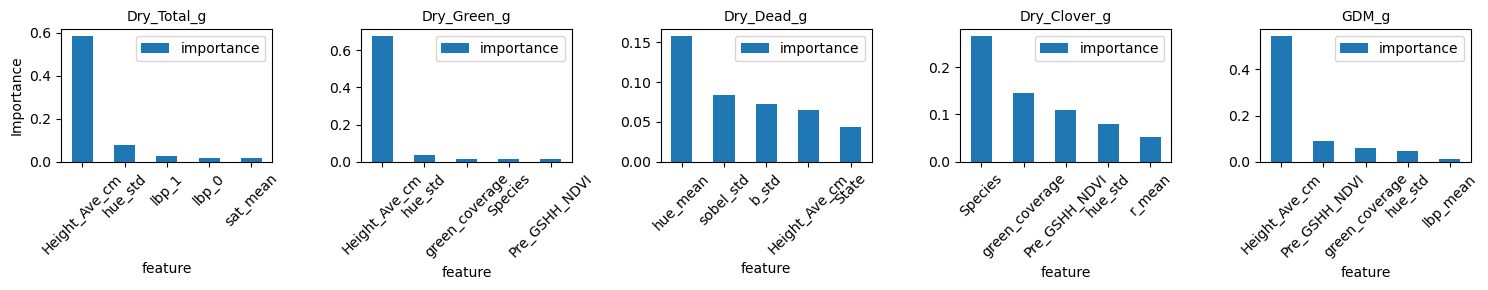

In [15]:
display(pd.DataFrame(forest_results))

fig , axes = plt.subplots( 1, len(comp_target.columns), figsize=(3 * len(comp_target.columns), 3) )
for i, target in enumerate(comp_target.columns):
    print(i, target)
    forest_models[i]['model'].importance.head(5).plot(kind='bar', x='feature', y='importance', ax=axes[i])
    axes[i].set_xticklabels(forest_models[i]['model'].importance.head(5)['feature'], rotation=45)
    axes[i].set_title(f'{target}', fontsize=10)

axes[0].set_ylabel('Importance', fontsize=10)
plt.tight_layout();plt.show()



In [16]:
%%time 
search_best_params = True

rf_trian_inputs = train_input
rf_valid_inputs = valid_input 

params_grid = { 'n_estimators': [100, 200], 'max_depth': [10, 20], 'learning_rate': [0.05, 0.1], 'subsample': [0.5, 0.8], 'colsample_bytree': [0.5, 0.8] }

best_xgb_params_list = []

for target in comp_target.columns:
    if search_best_params:  
        best_params, best_score = best_xgb_search(rf_trian_inputs, train_target[target], rf_valid_inputs, valid_target[target], params_grid)
        best_xgb_params_list.append({ 'target': target, 'best_params': best_params, 'best_score': best_score }) 

if search_best_params:
    filehander = open('stats/best_xgb_params_list.pkl', 'wb')
    pickle.dump(best_xgb_params_list, filehander)
    filehander.close()


CPU times: user 8.68 s, sys: 3.05 s, total: 11.7 s
Wall time: 2min 18s


In [17]:
%%time 
## XGBoost

best_xgb_params_list = pickle.load(open('stats/best_xgb_params_list.pkl', 'rb'))

xgb_models  = []
xgb_results = []
  
 
for i in range( len(best_xgb_params_list) ):
    
    target              = best_xgb_params_list[i]['target']
    max_depth           = best_xgb_params_list[i]['best_params']['max_depth']
    learning_rate       = best_xgb_params_list[i]['best_params']['learning_rate']
    subsample           = best_xgb_params_list[i]['best_params']['subsample']
    colsample_bytree = best_xgb_params_list[i]['best_params']['colsample_bytree']
    n_estimators = best_xgb_params_list[i]['best_params']['n_estimators']

    params = { 'max_depth': max_depth, 'learning_rate': learning_rate, 'subsample': subsample, 'colsample_bytree': colsample_bytree, 'n_estimators': n_estimators, 'random_state': 123, 'n_jobs': -1 }
    xgb_model = xgboost_regressor()
    xgb_model.fit_xgboost(train_input, train_target[target], valid_input, valid_target[target], verbose=False, **params)

    mae, mse, r2 = metrics(test_target[target], xgb_model.get_pred(test_input))
    xgb_models.append({ 'target': target, 'model': xgb_model })
    xgb_results.append({ 'target': target, 'mae': mae, 'mse': mse, 'r2': r2 })

display(pd.DataFrame(xgb_results))

,target,mae,mse,r2
0,Dry_Total_g,9.694264,156.275875,0.722901
1,Dry_Green_g,7.015281,73.707686,0.863512
2,Dry_Dead_g,6.491707,70.001220,0.210281
3,Dry_Clover_g,5.492762,97.994616,0.677792
4,GDM_g,7.090779,73.076268,0.871943


CPU times: user 6.19 s, sys: 2.66 s, total: 8.85 s
Wall time: 4.19 s


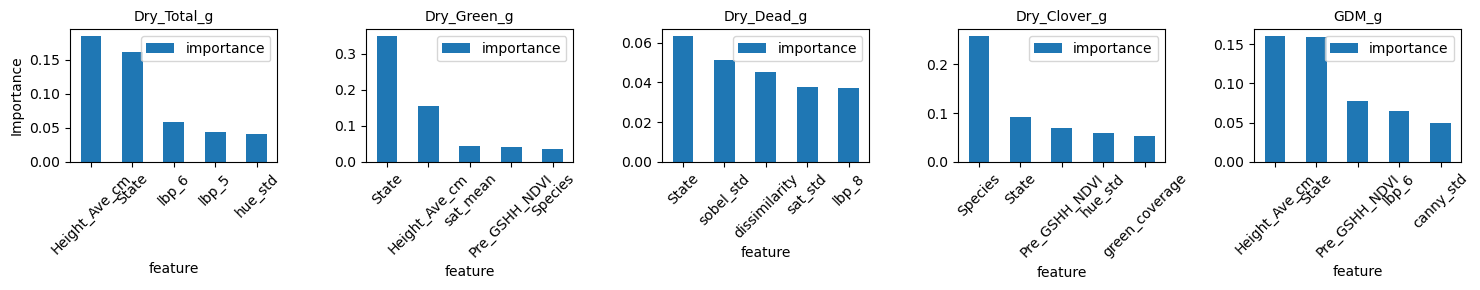

In [26]:
fig , axes = plt.subplots( 1, len(comp_target.columns), figsize=(3 * len(comp_target.columns), 3) )

for i, target in enumerate(comp_target.columns):
    model = xgb_models[i]['model']
    model.importance.head(5).plot(kind='bar', x='feature', y='importance', ax=axes[i])
    axes[i].set_xticklabels(model.importance.head(5)['feature'], rotation=45)
    axes[i].set_title(f'{target}', fontsize=10)
 

axes[0].set_ylabel('Importance', fontsize=10)
plt.tight_layout();plt.show()